In [7]:
!pip install hyperopt

  Using cached hyperopt-0.2.7-py2.py3-none-any.whl (1.6 MB)
     |████████████████████████████████| 199 kB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 829 kB 1.5 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 10.4 MB/s eta 0:00:01
  Using cached cloudpickle-2.1.0-py3-none-any.whl (25 kB)
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=ac71af753f3c1160c6a0b3f5007c35795d87af60b0b217ad8b4d6a86beacf5a8
  Stored in directory: /Users/przivic/Library/Caches/pip/wheels/2f/a0/d3/4030d9f80e6b3be787f19fc911b8e7aa462986a40ab1e4bb94
Successfully built future


In [1]:
!pip install --upgrade --force lightgbm

  Using cached lightgbm-3.3.2-py3-none-macosx_10_14_x86_64.macosx_10_15_x86_64.macosx_11_0_x86_64.whl (1.2 MB)
     |████████████████████████████████| 18.1 MB 5.4 MB/s eta 0:00:01
  Using cached scipy-1.8.1-cp39-cp39-macosx_12_0_universal2.macosx_10_9_x86_64.whl (55.6 MB)
^C
ERROR: Operation cancelled by user


In [1]:
import pandas as pd

import sys
sys.path.append('../../lib')

In [2]:
from taller_model_selection.serialize import iter_jl

In [3]:
X, y = map(list, map(iter_jl, ['X_train.jl', 'y_train.jl']))

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
len(X_train), len(y_train), len(X_dev), len(y_dev), len(X_test), len(y_test)

(121272, 121272, 20212, 20212, 20212, 20212)

In [63]:
from taller_model_selection.metrics import rmse
from taller_model_selection.transformers import FeatureProjection
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

features_pipe = make_union(
    make_pipeline(
        FeatureProjection(['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']),
        SimpleImputer()
    ),
    make_pipeline(
        FeatureProjection(['l3']), 
        SimpleImputer(strategy='most_frequent'),
        OneHotEncoder(sparse=False)
    ), 
    make_pipeline(
        FeatureProjection(['l4']), 
        SimpleImputer(strategy='constant'),
        OneHotEncoder(sparse=False)
    ), 
)

In [64]:
import lightgbm as lgb
from pprint import pprint
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from time import time

def eval_pipe(model_name, pipe):
    return dict(
        name=model_name,
        train=rmse(y_train, pipe.predict(X_train)),
        dev=rmse(y_dev, pipe.predict(X_dev))
    )

def rf_objective(params):
    params['n_estimators'] = int(params['n_estimators'])
    print(params)
    rf_pipe = make_pipeline(
        features_pipe,
        lgb.LGBMRegressor(random_state=42, **params)
    )
    t0 = time()
    rf_pipe.fit(X_train, y_train)
    train_time = time() - t0
    loss=rmse(y_dev, rf_pipe.predict(X_dev))
    print(f'loss {loss:.02f}')
    return dict(
        loss=loss,
        tr_loss=rmse(y_train, rf_pipe.predict(X_train)), 
        params=params,
        train_time=train_time,
        status=STATUS_OK
    )

In [65]:
import numpy as np

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 3000, 10),
    'subsample': hp.quniform('subsample', 0.5, 1.0, 0.1),
    'objective': hp.choice('objective', ["regression", "regression_l1"]),
    'learning_rate': hp.qloguniform('learning_rate', np.log(0.01), np.log(0.3), 0.01),
    'reg_alpha': hp.choice('ra', [0, hp.quniform('reg_alpha', 0.01, 0.1, 0.01)]),
}

trials = Trials()

In [66]:
best = fmin(rf_objective, space, algo=tpe.suggest, max_evals=1000, trials=trials)

{'learning_rate': 0.01, 'n_estimators': 2580, 'objective': 'regression', 'reg_alpha': 0.09, 'subsample': 0.8}
loss 308031.03                                                                  
{'learning_rate': 0.01, 'n_estimators': 2860, 'objective': 'regression', 'reg_alpha': 0.08, 'subsample': 0.7000000000000001}
loss 307555.46                                                                  
{'learning_rate': 0.15, 'n_estimators': 1500, 'objective': 'regression_l1', 'reg_alpha': 0, 'subsample': 0.5}
loss 328279.82                                                                  
{'learning_rate': 0.04, 'n_estimators': 350, 'objective': 'regression', 'reg_alpha': 0.04, 'subsample': 0.8}
loss 310182.88                                                                  
{'learning_rate': 0.04, 'n_estimators': 600, 'objective': 'regression_l1', 'reg_alpha': 0.04, 'subsample': 0.7000000000000001}
loss 336534.25                                                                  
{'learning_rat

{'learning_rate': 0.06, 'n_estimators': 1940, 'objective': 'regression', 'reg_alpha': 0.05, 'subsample': 0.7000000000000001}
loss 300934.31                                                                  
{'learning_rate': 0.09, 'n_estimators': 2170, 'objective': 'regression_l1', 'reg_alpha': 0.03, 'subsample': 0.6000000000000001}
loss 326414.81                                                                  
{'learning_rate': 0.15, 'n_estimators': 80, 'objective': 'regression', 'reg_alpha': 0.02, 'subsample': 0.8}
loss 311422.49                                                                  
{'learning_rate': 0.05, 'n_estimators': 1180, 'objective': 'regression_l1', 'reg_alpha': 0.01, 'subsample': 0.7000000000000001}
loss 329573.47                                                                  
{'learning_rate': 0.07, 'n_estimators': 1890, 'objective': 'regression', 'reg_alpha': 0.06, 'subsample': 0.7000000000000001}
loss 300650.09                                                

{'learning_rate': 0.14, 'n_estimators': 690, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 1.0}
loss 301324.23                                                                  
{'learning_rate': 0.09, 'n_estimators': 2100, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 1.0}
loss 300083.14                                                                  
{'learning_rate': 0.23, 'n_estimators': 2650, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.9}
loss 301839.00                                                                  
{'learning_rate': 0.05, 'n_estimators': 2220, 'objective': 'regression_l1', 'reg_alpha': 0, 'subsample': 1.0}
loss 327206.82                                                                  
{'learning_rate': 0.1, 'n_estimators': 920, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.9}
loss 302206.78                                                                  
{'learning_rate': 0.07, 'n_estimators': 2320, 'objective': '

{'learning_rate': 0.17, 'n_estimators': 1540, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 1.0}
loss 299926.82                                                                  
{'learning_rate': 0.08, 'n_estimators': 2290, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.9}
loss 300585.98                                                                  
{'learning_rate': 0.18, 'n_estimators': 2050, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 299629.63                                                                  
{'learning_rate': 0.1, 'n_estimators': 2620, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 1.0}
loss 299395.84                                                                  
{'learning_rate': 0.04, 'n_estimators': 620, 'objective': 'regression_l1', 'reg_alpha': 0, 'subsample': 1.0}
loss 335289.27                                                                  
{'learning_rate': 0.22, 'n_estimators': 1340, 'objective': 

{'learning_rate': 0.3, 'n_estimators': 700, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 1.0}
loss 301769.30                                                                  
{'learning_rate': 0.1, 'n_estimators': 2180, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.6000000000000001}
loss 299579.85                                                                  
{'learning_rate': 0.26, 'n_estimators': 1670, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 1.0}
loss 300039.11                                                                  
{'learning_rate': 0.06, 'n_estimators': 1800, 'objective': 'regression', 'reg_alpha': 0.09, 'subsample': 0.8}
loss 301134.94                                                                  
{'learning_rate': 0.05, 'n_estimators': 2450, 'objective': 'regression_l1', 'reg_alpha': 0, 'subsample': 0.9}
loss 327131.53                                                                  
{'learning_rate': 0.11, 'n_estimators': 14

{'learning_rate': 0.06, 'n_estimators': 2420, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 1.0}
loss 300301.68                                                                  
{'learning_rate': 0.08, 'n_estimators': 610, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 305332.95                                                                  
{'learning_rate': 0.3, 'n_estimators': 1230, 'objective': 'regression', 'reg_alpha': 0.04, 'subsample': 0.6000000000000001}
loss 300812.21                                                                  
{'learning_rate': 0.18, 'n_estimators': 1840, 'objective': 'regression_l1', 'reg_alpha': 0, 'subsample': 1.0}
loss 326168.46                                                                  
{'learning_rate': 0.13, 'n_estimators': 820, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.9}
loss 301748.84                                                                  
{'learning_rate': 0.07, 'n_estimators': 25

{'learning_rate': 0.1, 'n_estimators': 1040, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.9}
loss 301786.80                                                                  
{'learning_rate': 0.14, 'n_estimators': 1730, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 1.0}
loss 299161.05                                                                  
{'learning_rate': 0.13, 'n_estimators': 1890, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 1.0}
loss 299344.63                                                                  
{'learning_rate': 0.12, 'n_estimators': 1760, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 1.0}
loss 299895.42                                                                  
{'learning_rate': 0.2, 'n_estimators': 1980, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 1.0}
loss 300272.31                                                                  
{'learning_rate': 0.14, 'n_estimators': 1510, 'objective': 're

loss 300340.69                                                                  
{'learning_rate': 0.01, 'n_estimators': 1150, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.9}
loss 311714.52                                                                  
{'learning_rate': 0.02, 'n_estimators': 770, 'objective': 'regression', 'reg_alpha': 0.01, 'subsample': 0.8}
loss 310031.35                                                                  
{'learning_rate': 0.19, 'n_estimators': 2020, 'objective': 'regression_l1', 'reg_alpha': 0, 'subsample': 0.9}
loss 332103.21                                                                  
{'learning_rate': 0.06, 'n_estimators': 1390, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 1.0}
loss 302064.53                                                                  
{'learning_rate': 0.07, 'n_estimators': 1890, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 1.0}
loss 300509.01                                         

{'learning_rate': 0.11, 'n_estimators': 2100, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss 300106.72                                                                  
{'learning_rate': 0.19, 'n_estimators': 1940, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 300781.73                                                                  
{'learning_rate': 0.02, 'n_estimators': 2430, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 305006.93                                                                  
{'learning_rate': 0.22, 'n_estimators': 2170, 'objective': 'regression', 'reg_alpha': 0.02, 'subsample': 0.8}
loss 299940.57                                                                  
{'learning_rate': 0.17, 'n_estimators': 2640, 'objective': 'regression_l1', 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss 328716.02                                                                  
{'learning_rate': 0.09, 

{'learning_rate': 0.01, 'n_estimators': 2380, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.9}
loss 308172.94                                                                  
{'learning_rate': 0.11, 'n_estimators': 2140, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 300162.94                                                                  
{'learning_rate': 0.15, 'n_estimators': 1780, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.9}
loss 300000.23                                                                  
{'learning_rate': 0.28, 'n_estimators': 2720, 'objective': 'regression', 'reg_alpha': 0.08, 'subsample': 0.7000000000000001}
loss 301950.08                                                                  
{'learning_rate': 0.05, 'n_estimators': 2620, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 300556.50                                                                  
{'learning_rate': 0.21, 'n_estimators': 19

loss 299355.67                                                                  
{'learning_rate': 0.14, 'n_estimators': 2260, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 299042.38                                                                  
{'learning_rate': 0.18, 'n_estimators': 2020, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 299825.80                                                                  
{'learning_rate': 0.23, 'n_estimators': 2290, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 301370.70                                                                  
{'learning_rate': 0.2, 'n_estimators': 1800, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 300275.34                                                                  
{'learning_rate': 0.15, 'n_estimators': 2090, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 299788.82                                               

loss 298969.27                                                                  
{'learning_rate': 0.08, 'n_estimators': 2210, 'objective': 'regression', 'reg_alpha': 0.03, 'subsample': 0.5}
loss 300993.52                                                                  
{'learning_rate': 0.16, 'n_estimators': 2560, 'objective': 'regression', 'reg_alpha': 0.03, 'subsample': 0.8}
loss 300525.52                                                                  
{'learning_rate': 0.29, 'n_estimators': 2280, 'objective': 'regression', 'reg_alpha': 0.04, 'subsample': 0.8}
loss 300621.10                                                                  
{'learning_rate': 0.1, 'n_estimators': 2410, 'objective': 'regression', 'reg_alpha': 0.02, 'subsample': 0.8}
loss 299660.61                                                                  
{'learning_rate': 0.11, 'n_estimators': 2150, 'objective': 'regression_l1', 'reg_alpha': 0.04, 'subsample': 0.8}
loss 328629.16                             

loss 299087.55                                                                  
{'learning_rate': 0.16, 'n_estimators': 2510, 'objective': 'regression', 'reg_alpha': 0.07, 'subsample': 0.7000000000000001}
loss 300545.43                                                                  
{'learning_rate': 0.19, 'n_estimators': 2010, 'objective': 'regression', 'reg_alpha': 0.02, 'subsample': 0.8}
loss 300007.47                                                                  
{'learning_rate': 0.09, 'n_estimators': 2600, 'objective': 'regression', 'reg_alpha': 0.04, 'subsample': 0.8}
loss 299698.35                                                                  
{'learning_rate': 0.15, 'n_estimators': 1880, 'objective': 'regression_l1', 'reg_alpha': 0.02, 'subsample': 0.9}
loss 330885.50                                                                  
{'learning_rate': 0.11, 'n_estimators': 2710, 'objective': 'regression', 'reg_alpha': 0.06, 'subsample': 0.7000000000000001}
loss 299940.

loss 299831.30                                                                  
{'learning_rate': 0.21, 'n_estimators': 1650, 'objective': 'regression', 'reg_alpha': 0.07, 'subsample': 0.9}
loss 300975.71                                                                  
{'learning_rate': 0.24, 'n_estimators': 2110, 'objective': 'regression_l1', 'reg_alpha': 0.04, 'subsample': 0.8}
loss 332234.44                                                                  
{'learning_rate': 0.11, 'n_estimators': 2950, 'objective': 'regression', 'reg_alpha': 0.09, 'subsample': 0.7000000000000001}
loss 299885.66                                                                  
{'learning_rate': 0.16, 'n_estimators': 200, 'objective': 'regression', 'reg_alpha': 0.08, 'subsample': 0.6000000000000001}
loss 306553.75                                                                  
{'learning_rate': 0.18, 'n_estimators': 2700, 'objective': 'regression', 'reg_alpha': 0.03, 'subsample': 0.8}
loss 300020.6

loss 299136.99                                                                  
{'learning_rate': 0.17, 'n_estimators': 2340, 'objective': 'regression', 'reg_alpha': 0.03, 'subsample': 0.8}
loss 299628.91                                                                  
{'learning_rate': 0.1, 'n_estimators': 2670, 'objective': 'regression', 'reg_alpha': 0.04, 'subsample': 0.8}
loss 299570.47                                                                  
{'learning_rate': 0.13, 'n_estimators': 2230, 'objective': 'regression', 'reg_alpha': 0.05, 'subsample': 0.8}
loss 299075.23                                                                  
{'learning_rate': 0.09, 'n_estimators': 2780, 'objective': 'regression', 'reg_alpha': 0.04, 'subsample': 0.8}
loss 299608.15                                                                  
{'learning_rate': 0.08, 'n_estimators': 2400, 'objective': 'regression', 'reg_alpha': 0.03, 'subsample': 0.8}
loss 300749.29                                

{'learning_rate': 0.1, 'n_estimators': 2770, 'objective': 'regression', 'reg_alpha': 0.05, 'subsample': 0.7000000000000001}
loss 299596.83                                                                  
{'learning_rate': 0.11, 'n_estimators': 2590, 'objective': 'regression', 'reg_alpha': 0.05, 'subsample': 0.6000000000000001}
loss 300022.23                                                                  
{'learning_rate': 0.13, 'n_estimators': 2670, 'objective': 'regression', 'reg_alpha': 0.04, 'subsample': 0.5}
loss 299082.08                                                                  
{'learning_rate': 0.2, 'n_estimators': 2980, 'objective': 'regression', 'reg_alpha': 0.04, 'subsample': 0.6000000000000001}
loss 299630.88                                                                  
{'learning_rate': 0.12, 'n_estimators': 2840, 'objective': 'regression', 'reg_alpha': 0.05, 'subsample': 0.7000000000000001}
loss 299599.01                                                      

{'learning_rate': 0.14, 'n_estimators': 2950, 'objective': 'regression', 'reg_alpha': 0.05, 'subsample': 0.8}
loss 299455.72                                                                  
{'learning_rate': 0.1, 'n_estimators': 2530, 'objective': 'regression', 'reg_alpha': 0.03, 'subsample': 0.8}
loss 299678.37                                                                  
{'learning_rate': 0.11, 'n_estimators': 2290, 'objective': 'regression', 'reg_alpha': 0.04, 'subsample': 0.8}
loss 300008.08                                                                  
{'learning_rate': 0.21, 'n_estimators': 2710, 'objective': 'regression_l1', 'reg_alpha': 0.06, 'subsample': 0.9}
loss 329103.54                                                                  
{'learning_rate': 0.13, 'n_estimators': 2050, 'objective': 'regression', 'reg_alpha': 0.05, 'subsample': 0.7000000000000001}
loss 299103.92                                                                  
{'learning_rate': 0.15, 'n_e

loss 301415.99                                                                  
{'learning_rate': 0.13, 'n_estimators': 2370, 'objective': 'regression', 'reg_alpha': 0.05, 'subsample': 0.8}
loss 298977.80                                                                  
{'learning_rate': 0.14, 'n_estimators': 2110, 'objective': 'regression', 'reg_alpha': 0.06, 'subsample': 0.7000000000000001}
loss 299284.73                                                                  
{'learning_rate': 0.05, 'n_estimators': 2350, 'objective': 'regression', 'reg_alpha': 0.07, 'subsample': 0.9}
loss 301247.11                                                                  
{'learning_rate': 0.09, 'n_estimators': 2180, 'objective': 'regression', 'reg_alpha': 0.07, 'subsample': 0.8}
loss 299907.13                                                                  
{'learning_rate': 0.18, 'n_estimators': 2850, 'objective': 'regression', 'reg_alpha': 0.06, 'subsample': 0.7000000000000001}
loss 300269.76 

loss 299849.38                                                                  
{'learning_rate': 0.11, 'n_estimators': 2360, 'objective': 'regression_l1', 'reg_alpha': 0.08, 'subsample': 0.9}
loss 328592.45                                                                  
{'learning_rate': 0.1, 'n_estimators': 1930, 'objective': 'regression', 'reg_alpha': 0.06, 'subsample': 1.0}
loss 300105.44                                                                  
{'learning_rate': 0.02, 'n_estimators': 2190, 'objective': 'regression', 'reg_alpha': 0.04, 'subsample': 0.9}
loss 305377.00                                                                  
{'learning_rate': 0.15, 'n_estimators': 2420, 'objective': 'regression', 'reg_alpha': 0.05, 'subsample': 0.9}
loss 299863.20                                                                  
{'learning_rate': 0.08, 'n_estimators': 2270, 'objective': 'regression', 'reg_alpha': 0.03, 'subsample': 0.9}
loss 300944.87                             

loss 299162.28                                                                  
{'learning_rate': 0.1, 'n_estimators': 2260, 'objective': 'regression', 'reg_alpha': 0.05, 'subsample': 0.8}
loss 299720.10                                                                  
{'learning_rate': 0.13, 'n_estimators': 2130, 'objective': 'regression', 'reg_alpha': 0.04, 'subsample': 0.8}
loss 299127.13                                                                  
{'learning_rate': 0.12, 'n_estimators': 2560, 'objective': 'regression', 'reg_alpha': 0.05, 'subsample': 0.8}
loss 299416.74                                                                  
{'learning_rate': 0.15, 'n_estimators': 2310, 'objective': 'regression', 'reg_alpha': 0.06, 'subsample': 0.8}
loss 299862.39                                                                  
{'learning_rate': 0.18, 'n_estimators': 2430, 'objective': 'regression', 'reg_alpha': 0.04, 'subsample': 0.8}
loss 299854.86                                

loss 299686.09                                                                  
{'learning_rate': 0.13, 'n_estimators': 2410, 'objective': 'regression', 'reg_alpha': 0.04, 'subsample': 0.8}
loss 298987.40                                                                  
{'learning_rate': 0.2, 'n_estimators': 1880, 'objective': 'regression', 'reg_alpha': 0.03, 'subsample': 0.9}
loss 299503.73                                                                  
{'learning_rate': 0.08, 'n_estimators': 2210, 'objective': 'regression', 'reg_alpha': 0.04, 'subsample': 0.8}
loss 300993.52                                                                  
{'learning_rate': 0.17, 'n_estimators': 2100, 'objective': 'regression', 'reg_alpha': 0.04, 'subsample': 1.0}
loss 299717.52                                                                  
{'learning_rate': 0.1, 'n_estimators': 2560, 'objective': 'regression', 'reg_alpha': 0.04, 'subsample': 0.9}
loss 299612.06                                 

{'learning_rate': 0.02, 'n_estimators': 2610, 'objective': 'regression', 'reg_alpha': 0.03, 'subsample': 0.7000000000000001}
loss 304764.46                                                                  
{'learning_rate': 0.16, 'n_estimators': 2410, 'objective': 'regression', 'reg_alpha': 0.05, 'subsample': 0.7000000000000001}
loss 300546.73                                                                  
{'learning_rate': 0.18, 'n_estimators': 2090, 'objective': 'regression', 'reg_alpha': 0.04, 'subsample': 0.7000000000000001}
loss 299915.67                                                                  
{'learning_rate': 0.2, 'n_estimators': 2360, 'objective': 'regression', 'reg_alpha': 0.02, 'subsample': 0.6000000000000001}
loss 299809.96                                                                  
{'learning_rate': 0.11, 'n_estimators': 2260, 'objective': 'regression', 'reg_alpha': 0.03, 'subsample': 0.7000000000000001}
loss 300018.44                                      

loss 301806.74                                                                  
{'learning_rate': 0.04, 'n_estimators': 1990, 'objective': 'regression', 'reg_alpha': 0.02, 'subsample': 0.7000000000000001}
loss 302266.55                                                                  
{'learning_rate': 0.11, 'n_estimators': 1660, 'objective': 'regression', 'reg_alpha': 0.04, 'subsample': 0.7000000000000001}
loss 300272.15                                                                  
{'learning_rate': 0.09, 'n_estimators': 2290, 'objective': 'regression', 'reg_alpha': 0.03, 'subsample': 0.7000000000000001}
loss 299864.30                                                                  
{'learning_rate': 0.07, 'n_estimators': 2610, 'objective': 'regression', 'reg_alpha': 0.04, 'subsample': 0.6000000000000001}
loss 299822.30                                                                  
{'learning_rate': 0.15, 'n_estimators': 2210, 'objective': 'regression', 'reg_alpha': 0.05, 'su

loss 332986.30                                                                  
{'learning_rate': 0.22, 'n_estimators': 2660, 'objective': 'regression', 'reg_alpha': 0.05, 'subsample': 0.7000000000000001}
loss 300363.95                                                                  
{'learning_rate': 0.12, 'n_estimators': 2830, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.6000000000000001}
loss 299587.19                                                                  
{'learning_rate': 0.18, 'n_estimators': 2340, 'objective': 'regression', 'reg_alpha': 0.03, 'subsample': 0.7000000000000001}
loss 299921.00                                                                  
{'learning_rate': 0.14, 'n_estimators': 2010, 'objective': 'regression', 'reg_alpha': 0.05, 'subsample': 1.0}
loss 299347.18                                                                  
{'learning_rate': 0.13, 'n_estimators': 2450, 'objective': 'regression', 'reg_alpha': 0.04, 'subsample': 0.700000

In [67]:
def flatten(doc, pref=''):
    res = {}
    for k, v in doc.items():
        k = f'{pref}.{k}' if pref else k
        if isinstance(v, dict):
            res.update(flatten(v, k))
        else:
            res[k] = v
    return res

In [69]:
import pandas as pd
df = pd.DataFrame(list(map(flatten, [e['result'] for e in trials.trials])))
df.sort_values('loss').head()

,loss,tr_loss,params.learning_rate,params.n_estimators,params.objective,params.reg_alpha,params.subsample,train_time,status
634,298923.716985,228704.235626,0.13,2360,regression,0.04,0.7,4.504366,ok
579,298923.716985,228704.235626,0.13,2360,regression,0.04,0.8,4.490871,ok
914,298962.620421,229039.443760,0.13,2310,regression,0.04,0.7,4.433737,ok
746,298962.620426,229039.443816,0.13,2310,regression,0.05,0.9,4.884760,ok
907,298962.620426,229039.443816,0.13,2310,regression,0.05,0.7,4.703802,ok


In [84]:
import pickle as pkl
1/0
with open('trials.pkl', 'wb') as f:
    pkl.dump(trials, f)

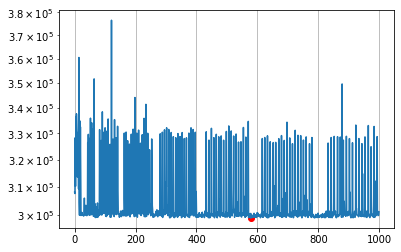

In [85]:
import matplotlib.pyplot as plt

df.loss.plot()
plt.scatter([df.loss.argmin()], [df.loss.min()], c='r')
# df.tr_loss.plot()
plt.yscale('log')
plt.grid()

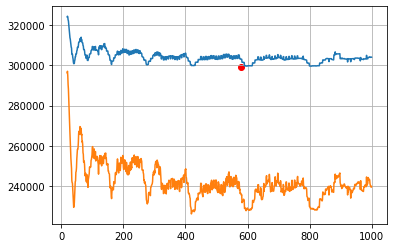

In [88]:

df.loss.rolling(20).mean().plot()
plt.scatter([df.loss.argmin()], [df.loss.min()], c='r')
df.tr_loss.rolling(20).mean().plot()
plt.grid()

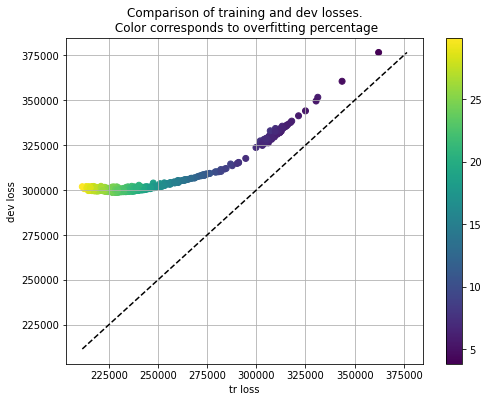

In [115]:
plt.figure(figsize=(8,6))
plt.scatter(df.tr_loss, df.loss, c=(df.loss-df.tr_loss)/df.loss*100)
plt.title('Comparison of training and dev losses.\n Color corresponds to overfitting percentage')
plt.colorbar()
m = min(df.tr_loss.min(), df.loss.min())
M = max(df.tr_loss.max(), df.loss.max())
plt.plot([m, M], [m, M], 'k--')
plt.xlabel('tr loss')
plt.ylabel('dev loss')
plt.grid()

In [116]:
best = df[df.loss < df.loss.min() * 1.001].sort_values('tr_loss', ascending=False).head(30)
best

,loss,tr_loss,params.learning_rate,params.n_estimators,params.objective,params.reg_alpha,params.subsample,train_time,status,score
77,299221.864446,235478.103361,0.14,1460,regression,0.00,1.0,3.260258,ok,-235478.103361
289,299083.208546,233732.075608,0.14,1610,regression,0.00,1.0,3.511403,ok,-233732.075608
117,299151.785484,233138.195638,0.14,1670,regression,0.00,1.0,3.728529,ok,-233138.195638
147,299161.054625,232546.925179,0.14,1730,regression,0.00,1.0,3.837287,ok,-232546.925179
257,299161.054625,232546.925179,0.14,1730,regression,0.00,1.0,3.621785,ok,-232546.925179
500,299183.581488,232309.084073,0.13,1920,regression,0.05,0.8,4.071576,ok,-232309.084073
73,299102.303181,232090.719539,0.14,1780,regression,0.00,1.0,3.647600,ok,-232090.719539
712,299168.587297,231548.172805,0.13,2000,regression,0.05,0.8,4.122056,ok,-231548.172805
559,299183.105988,231363.701008,0.13,2020,regression,0.06,0.9,7.445719,ok,-231363.701008
985,299113.721006,231260.397753,0.13,2030,regression,0.03,0.7,4.143197,ok,-231260.397753


In [124]:
params = {k.replace('params.', ''):v for k, v in best.iloc[0].to_dict().items() if 'params.' in k}
rf_pipe = make_pipeline(
    features_pipe,
    lgb.LGBMRegressor(random_state=42, **params)
)
rf_pipe.fit(X_train, y_train)

best_model_performance = dict(
    tr_loss=rmse(y_train, rf_pipe.predict(X_train)), 
    dev_loss=rmse(y_dev, rf_pipe.predict(X_dev)),
    test_loss=rmse(y_test, rf_pipe.predict(X_test)), 
)
best_model_performance

{'tr_loss': 235478.10336061733,
 'dev_loss': 299221.8644455432,
 'test_loss': 265307.85308950214}